# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import operator
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.shape,azdias.shape

((85, 4), (891221, 85))

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
null_column_count=azdias.isnull().sum()
null_column_count


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
null_columns_before=azdias.isnull().sum()[azdias.isnull().sum()!=0]
null_columns_before.sum()
print('the total number of missing values before conversion is {}'.format(null_columns_before.sum()))

the total number of missing values before conversion is 4896838


In [10]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [11]:
null_columns_after=azdias.isnull().sum()[azdias.isnull().sum()!=0]
null_columns_after.sum()
print('the total number of missing values after conversion is {}'.format(null_columns_after.sum()))

the total number of missing values after conversion is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_dict={"null_count":null_columns_after.values,"percent":np.round(null_columns_after.values/len(azdias)*100,2)}
azdias_null =pd.DataFrame(data=null_dict,index =null_columns_after.index)
azdias_null.sort_values(by="null_count",ascending=False,inplace=True)

azdias_null

,null_count,percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


In [13]:
# Investigate patterns in the amount of missing data in each column.
percent_null_columns = null_columns_after.sort_values()/len(azdias)*100
percent_null_columns


ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
'''for this data the outliers can be seen from the above dataframe:columns with more than 20% missing values, since most columns contained less than 30 percent missing values'''
missing_values_greater_30per =[]
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 32:
        missing_values_greater_30per.append(col)
#missing_values_greater_30per

In [15]:
azdias.drop(missing_values_greater_30per,axis=1).shape

(891221, 79)

In [16]:
azdias = azdias.drop(missing_values_greater_30per,axis=1)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most columns have less than 20 percent missing values.only six columns have more than 32 percent missing data and were dropped. these columns are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?

null_row_count=azdias.isnull().sum(axis=1)
null_row_count
null_row =azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1)!=0]
null_row

0         43
3          7
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
20        10
23         8
24        47
25         5
26        19
29         2
30        34
34         4
35        43
39         5
40         4
42         2
46        40
48        47
53        43
54        47
60         4
61        43
62        43
64         5
          ..
891129     8
891130    34
891135     6
891136     2
891137    34
891139     7
891140    34
891150     3
891154    11
891155     4
891157     4
891159    43
891161     3
891162     6
891164    43
891169    18
891170    19
891171    34
891172    16
891173    19
891175    47
891181     3
891184     8
891185    47
891187    47
891203    14
891208     3
891216     3
891217     4
891218     5
Length: 268012, dtype: int64

In [18]:
null_row.describe()

count    268012.000000
mean         18.787607
std          18.320049
min           1.000000
25%           4.000000
50%           8.000000
75%          43.000000
max          49.000000
dtype: float64

In [19]:
null_row_dict={"null_count":null_row.values,"percent":np.round(null_row.values/85*100,2)}
azdias_null_row =pd.DataFrame(data=null_row_dict,index =null_row.index)
azdias_null_row.sort_values(by="null_count",ascending=False,inplace=True)

azdias_null_row

,null_count,percent
643174,49,57.65
732775,49,57.65
472919,48,56.47
128995,47,55.29
825248,47,55.29
739932,47,55.29
571655,47,55.29
530963,47,55.29
739937,47,55.29
530964,47,55.29


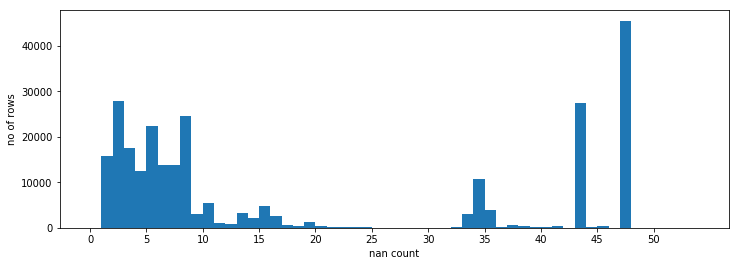

In [20]:

plt.figure(figsize=(12,4))
plt.hist(null_row, bins=np.arange(0,55,1))
plt.xlabel('nan count')
plt.ylabel('no of rows')
plt.xticks(np.arange(0,55,5));

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lower_30 = azdias[azdias.isnull().sum(axis=1) <= 30]
azdias_more_30 = azdias[azdias.isnull().sum(axis=1) > 30]


In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_null_columns =azdias.isnull().sum()[azdias.isnull().sum()==0].index.tolist()
no_null_columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [23]:
compare_columns = no_null_columns[-6:]

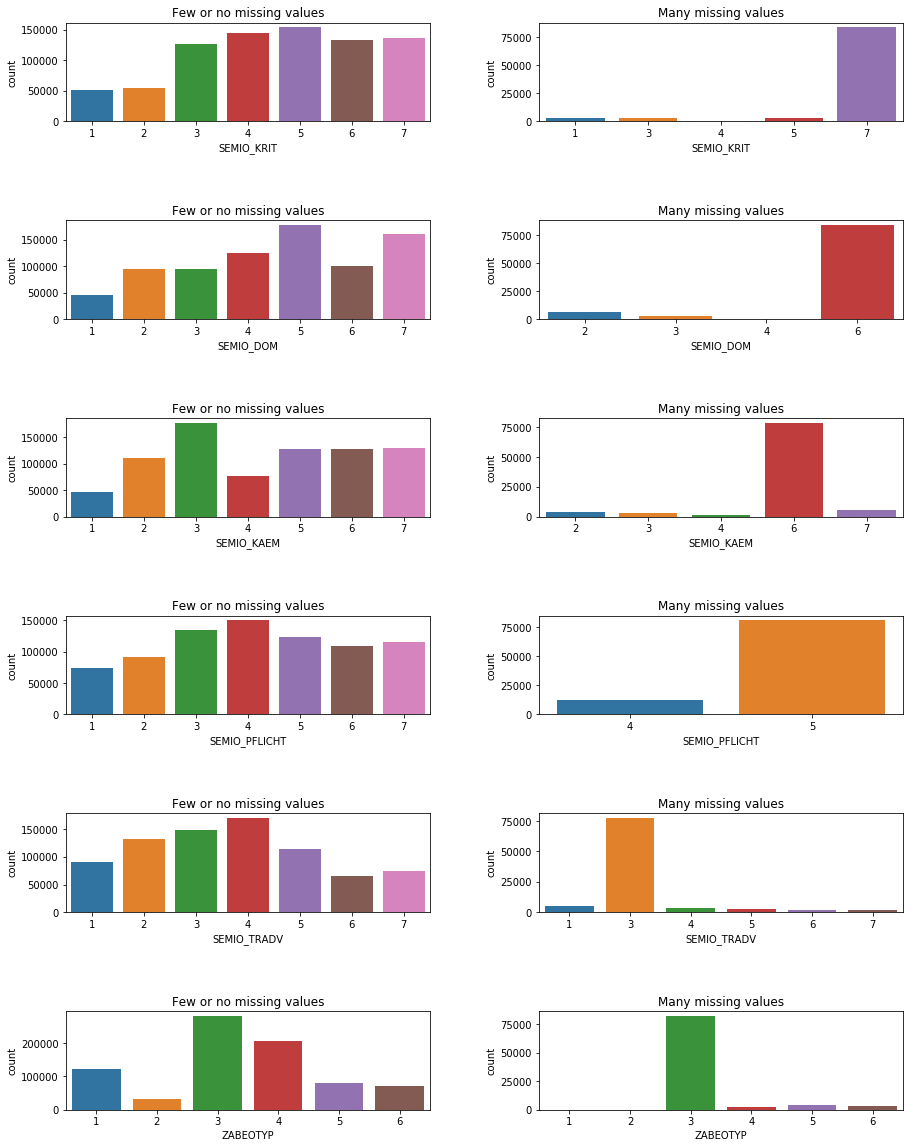

In [24]:
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(azdias_lower_30 [compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_more_30[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row
the maximum number of missing values in a row is 49. I analyzed the last five rows in the dataset.Focusing on columns which have no or very low missing values, we can see that the distribution of values between the two subsets is qualitatively different. The plots above are not perfect (not same scale, not very readable) but they still provide a good idea of what is going on: different distribution of values between the rows with high vs. low missing values. we can also see some values were captured for in the  many missing values columns.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info.head(3)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


In [26]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values

In [28]:
# selecting the categorical columns in azdias now
categorical_columns = [categorical_column for categorical_column in categorical_columns if categorical_column in azdias.columns] 
categorical_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [29]:
azdias[categorical_columns].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [30]:
binary_categoricals = []
multi_level_categoricals = []
for column in categorical_columns:
    if azdias[column].nunique() > 2:
        multi_level_categoricals.append(column)
    else:
        binary_categoricals.append(column)

In [31]:
for c in binary_categoricals:
    print(azdias[c].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [32]:
# Encode binary columns 
azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
#dropping all multi_level_catergoricals
azdias.drop(multi_level_categoricals, axis=1, inplace=True)


#### Discussion 1.2.1: Re-Encode Categorical Features
 I re-encoded the binary columns properly with  [0,1].Then, I dropped all the multilevel categorical features. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()


,PRAEGENDE_JUGENDJAHRE
0,NaN
1,14.0
2,15.0
3,8.0
4,8.0


In [35]:
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE']

In [36]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [37]:
azdias['DECADE'].replace(decade_dict, inplace=True)
azdias['MOVEMENT'].replace(movement_dict, inplace=True)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].value_counts()


51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [39]:
azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']

In [40]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [41]:
azdias['WEALTH'].replace(wealth_dict, inplace=True)
azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [42]:
 #Drop features we don't use anymore 
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)


In [43]:
azdias.shape

(891221, 68)

In [44]:
azdias.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features
 I created genereation and movement features from column PRAEGENDE_JUGENDJAHRE by mapping the values with the data dictionary. I also did same for column CAMEO_INTL_2015 by creating  the wealth and life stage features were made.
I dropped the  two original columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias.dtypes.value_counts()

float64    46
int64      22
dtype: int64

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
data= azdias[azdias.isnull().sum(axis=1) <= 30]
data.dtypes.value_counts()


float64    46
int64      22
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # cooverting missing or unknown to standard numpy Nan values
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df= df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...

    missing_values_greater_30per =[]
    for col in df.columns:
        if (df[col].isnull().sum()/df.shape[0]) * 100 > 32:
             missing_values_greater_30per.append(col)
    df = df.drop(missing_values_greater_30per,axis=1)
    # select, re-encode, and engineer column values.
   #Recode categorical features
    categorical_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
    categorical_columns = [categorical_column for categorical_column in categorical_columns if categorical_column in df.columns] 
    binary_categoricals = []
    multi_level_categoricals = []
    for column in categorical_columns:
        if df[column].nunique() > 2:
            multi_level_categoricals.append(column)
        else:
            binary_categoricals.append(column)
     #reEncode binary columns
    try:
        df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    #dropping all multi_level_catergoricals
    df.drop(multi_level_categoricals,axis=1,inplace=True)

    # feature engineering:creating twon new features from PRAEGENDE_JUGENDJARHE
    try:
        df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    except:
        print('Skipped a preprocessing step due to column already dropped')
        
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    try:
        df['DECADE'].replace(decade_dict, inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['MOVEMENT'].replace(movement_dict, inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    
    #creating two new features from CAMEO_INTL_2015
    try:
        df['WEALTH'] = df['CAMEO_INTL_2015']
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['LIFE_STAGE'] =df['CAMEO_INTL_2015']
    except:
        print('Skipped a preprocessing step due to column already dropped')

    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    try:
        df['WEALTH'].replace(wealth_dict, inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    try:
        df['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    except:
        print('Skipped a preprocessing step due to column already dropped')
    
     
    #Drop features we don't use anymore 

    try:
        df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    except:
        print('Skipped a preprocessing step due to column already dropped')
        
    df=df[df.isnull().sum(axis=1) <= 30]

    
    # Return the cleaned dataframe.
    return df
    
    

In [48]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

features = data.copy()
col_list = features.columns

# Impute nans
imputer = Imputer(strategy='median')
imputed_features = imputer.fit_transform(features)

In [50]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)
standardized_features = pd.DataFrame(standardized_features, columns= col_list)
standardized_features


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766229,0.957934,-1.494448,1.537517,-1.040685,1.465454,0.958063,1.339513,-0.530317,1.096695,...,-0.633153,1.430514,0.574466,-0.166364,-0.127022,0.684986,1.172665,0.530317,1.186215,-1.267244
1,0.200686,0.957934,-1.494448,0.864216,-1.767027,-0.571254,0.243679,1.339513,1.885665,1.096695,...,-0.633153,0.390705,0.574466,-0.166364,-0.127022,-0.789114,1.172665,-1.885665,-0.868456,0.761372
2,1.184144,0.957934,0.683290,-0.482386,1.138338,-0.571254,-1.185090,-0.791166,-0.530317,-0.256934,...,-0.633153,-0.649105,0.574466,-1.170006,-0.997639,-0.052064,-0.223681,0.530317,-1.553346,-0.591039
3,0.200686,-1.043913,0.683290,0.190915,0.411997,-1.250157,0.243679,-0.791166,-0.530317,1.096695,...,0.058031,-0.649105,-0.337144,0.837278,0.308287,1.422036,-0.223681,0.530317,0.501325,0.085166
4,-1.766229,0.957934,-0.042623,-1.155687,1.138338,-0.571254,-0.470706,1.339513,-0.530317,1.096695,...,-0.633153,1.430514,1.486076,-1.170006,-0.997639,-0.052064,-1.620028,0.530317,1.186215,0.761372
5,-0.782772,0.957934,-1.494448,1.537517,-1.767027,1.465454,0.958063,-0.080939,-0.530317,-0.256934,...,-0.633153,1.430514,1.486076,0.837278,0.308287,-0.052064,0.474492,0.530317,-0.868456,-0.591039
6,-1.766229,-1.043913,-0.042623,0.190915,0.411997,-1.250157,0.243679,-0.791166,-0.530317,-1.610562,...,-0.633153,0.390705,0.574466,-1.170006,-0.127022,-0.789114,-0.223681,0.530317,-1.553346,0.761372
7,0.200686,-1.043913,0.683290,0.864216,-1.040685,0.786551,-0.470706,-0.791166,1.885665,1.096695,...,-0.633153,-0.649105,-0.337144,-1.170006,-0.562330,-0.052064,0.474492,-1.885665,-1.553346,0.085166
8,0.200686,0.957934,-0.768535,0.864216,-1.040685,0.107649,1.672448,0.629287,1.885665,-0.256934,...,-0.633153,-0.649105,-0.337144,-1.170006,-0.997639,-1.526164,1.172665,-1.885665,-1.553346,1.437577
9,0.200686,0.957934,-0.768535,-0.482386,1.138338,0.107649,-1.185090,1.339513,-0.530317,-0.256934,...,0.058031,-0.649105,-0.337144,0.837278,0.308287,1.422036,-1.620028,0.530317,1.186215,-1.267244


### Discussion 2.1: Apply Feature Scaling

i filled in the nan values with  median value  and applied StandardScaler to standardize features to achieve a mean of 0 and standard deviation of 1 in the demographic data

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(standardized_features)
pca_features = pd.DataFrame(pca_features, columns= col_list)


In [52]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

code above extracted from Udacity lectures.

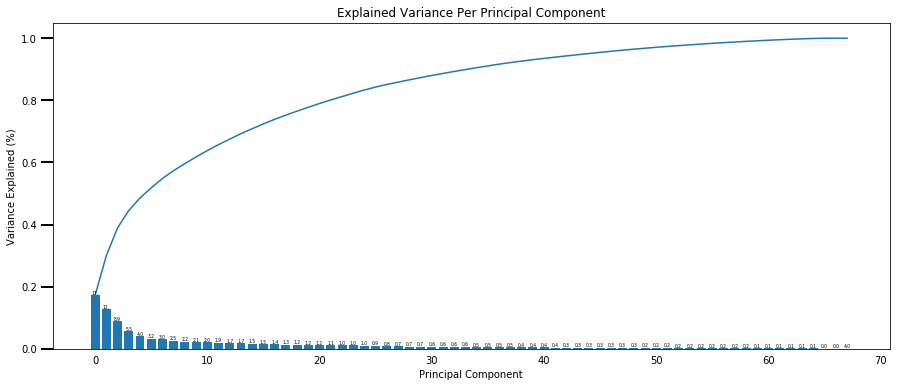

In [53]:
scree_plot(pca)

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(30)
pca_features = pca.fit_transform(standardized_features)


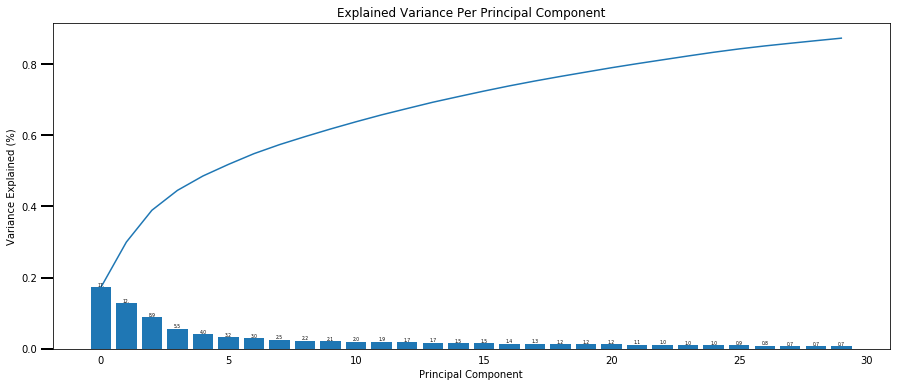

In [55]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

PCA was first applied to a set of components. i selected 30 components and re applied PCA for this component . 30 component of this data set gives about 80

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights_of_pca(pca, i):
    weight_map = {}
    for counter, feature in enumerate(standardized_features.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    sorted_weights = sorted(weight_map.items(), key= operator.itemgetter(1), reverse=True)
    sorted_weights =pd.DataFrame(data=sorted_weights,columns=['Feature','Weights'])
    
    return sorted_weights

In [57]:
weights_pc1 =weights_of_pca(pca, 1)
weights_pc1


,Feature,Weights
0,ALTERSKATEGORIE_GROB,0.272155
1,FINANZ_VORSORGER,0.244672
2,SEMIO_ERL,0.235784
3,SEMIO_LUST,0.191013
4,RETOURTYP_BK_S,0.164732
5,W_KEIT_KIND_HH,0.117167
6,SEMIO_KRIT,0.112139
7,SEMIO_KAEM,0.103599
8,FINANZ_HAUSBAUER,0.095114
9,FINANZ_MINIMALIST,0.094252


In [58]:
weights_pc1['Feature'][0:6]

0    ALTERSKATEGORIE_GROB
1        FINANZ_VORSORGER
2               SEMIO_ERL
3              SEMIO_LUST
4          RETOURTYP_BK_S
5          W_KEIT_KIND_HH
Name: Feature, dtype: object

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc2=weights_of_pca(pca,2)


weights_pc2

,Feature,Weights
0,SEMIO_VERT,0.346355
1,SEMIO_SOZ,0.262296
2,SEMIO_FAM,0.249785
3,SEMIO_KULT,0.235745
4,FINANZ_MINIMALIST,0.160962
5,RETOURTYP_BK_S,0.106383
6,FINANZ_VORSORGER,0.100031
7,W_KEIT_KIND_HH,0.086515
8,ALTERSKATEGORIE_GROB,0.077796
9,SEMIO_REL,0.069895


In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc3=weights_of_pca(pca,3)

weights_pc3

,Feature,Weights
0,GREEN_AVANTGARDE,0.350255
1,EWDICHTE,0.247572
2,ORTSGR_KLS9,0.246659
3,LP_LEBENSPHASE_FEIN,0.215997
4,LP_LEBENSPHASE_GROB,0.212924
5,ANZ_PERSONEN,0.193242
6,ONLINE_AFFINITAET,0.171225
7,SEMIO_DOM,0.113137
8,RELAT_AB,0.107484
9,PLZ8_ANTG3,0.104441


### Discussion 2.3: Interpret Principal Components

### Principal Component 1:
For The strongest positive feature weights: ALTERSKATEGORIE_GROB and FINANZ_VORSORGER which implies that the estimated age and finacially prepared class  have sizable roles in explaining the variation due to that PC
The strongest negative feature weights: SEMIO_REL and decade which implies  that the PC captured religious persons and decade  also have sizable roles but in an opposed way. 

### Principal Component 2:
For The strongest positive feature weights:  SEMIO_VERT and  SEMIO_SOZ  both belong to personality typology  and have high weights in this PC.
The strongest negative feature weights:  ANREDE and SEMIO_KAEM which implies  that the gender  and combactive attitude have sizable roles in explaining the variation.
this Pc seems to capture a persons personality typology in relation to their gender in essence personal level features.

### Principal Component 3:
For The strongest positive feature weights: GREEN_AVANTGARDE and EWDICHTE  which implies that membership in environmental sustainability as part of youth and density of household of house hold per km  have sizable roles in explaining the variation due to that PC
The strongest negative feature weights: WOHNLAGE and MOVEMENT which implies  that the PC captured the neighbourhood quality and decade  also have sizable roles but in an opposed way. 
notice  there is a perfect contrast between GREEN_AVANTGARDE and MOVEMENT in this PC




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
# Over a number of different cluster counts...

def kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
    
    

In [62]:
scores = []

centers = np.arange(25, 45, 5)

for center in centers: 
    scores.append(kmeans_score(pca_features, center))

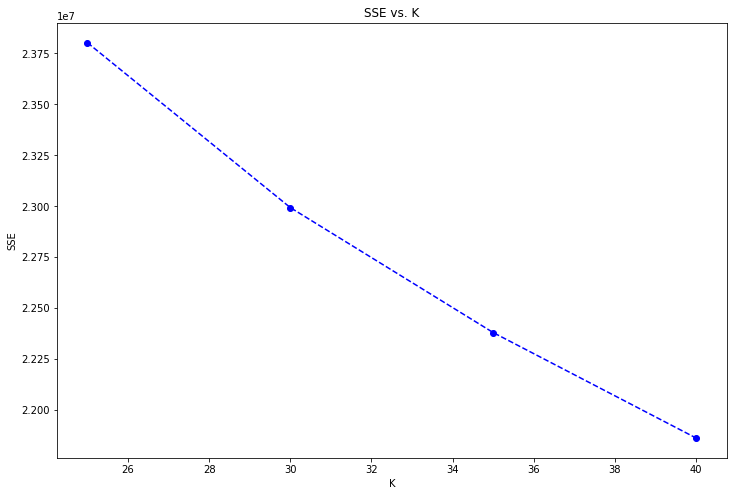

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12, 8)) 
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

plt.show()

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=28)
model_gen = kmeans.fit_predict(pca_features)


### Discussion 3.1: Apply Clustering to General Population

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data
customers_clean = clean_data(customers)
cols = customers_clean.columns

In [67]:
customers_clean= imputer.transform(customers_clean)
customers_clean= scaler.transform(customers_clean)
customers_clean= pca.transform(customers_clean)

prediction = kmeans.predict(customers_clean)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
s1 = pd.Series(model_gen,name = 'Population_Cluster_Proportion' ).value_counts(normalize = True).sort_values()*100
s2 = pd.Series(prediction,name = 'Customers_Cluster_Proportion').value_counts(normalize = True).sort_values()*100

analysis = pd.concat([s1, s2], axis=1)

analysis['ratio_of_overrep'] = round(analysis['Customers_Cluster_Proportion']/analysis['Population_Cluster_Proportion'],1)
analysis.sort_values(by = 'ratio_of_overrep', ascending = False)


,Population_Cluster_Proportion,Customers_Cluster_Proportion,ratio_of_overrep
15,5.411398,27.425919,5.1
18,0.386332,1.876971,4.9
2,4.206054,11.586291,2.8
24,0.094078,0.233475,2.5
26,5.098600,9.912464,1.9
6,4.782043,8.048190,1.7
16,4.285850,6.934422,1.6
0,4.854825,5.181596,1.1
25,0.836425,0.960704,1.1
7,4.590381,4.215954,0.9


In [69]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

orig_cust = scaler.inverse_transform(pca.inverse_transform(customers_clean))


In [70]:
orig_cust = pd.DataFrame(orig_cust, columns = cols)
orig_cust['cluster'] = prediction

In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

over = orig_cust[(orig_cust['cluster']==5) | (orig_cust['cluster']==4) | (orig_cust['cluster']==22)]
under = orig_cust[(orig_cust['cluster']==0) | (orig_cust['cluster']==25) | (orig_cust['cluster']==24)]

In [72]:
over.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,...,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000
mean,3.133244,0.507075,3.103793,2.073248,4.110124,1.830844,2.015556,3.592671,0.280031,2.216746,...,3.756879,2.607749,3.439410,7.145846,3.660369,3.724135,0.719969,3.731557,2.718482,9.730128
std,0.767496,0.497934,0.731770,1.041979,1.141091,1.208590,1.160289,1.135788,0.448410,0.713066,...,0.761079,1.017376,0.687867,1.466935,1.044232,1.158738,0.448410,1.145021,1.563548,8.197119
min,0.725101,-0.329146,0.051244,0.473323,0.811010,-0.563581,-0.316570,-0.338771,-0.115842,0.576239,...,1.231541,0.267439,0.895537,0.942867,-0.255302,1.629939,-0.135258,0.117390,0.172545,4.000000
25%,2.825636,0.024922,2.711887,1.221447,3.364322,0.874451,1.188384,2.913106,-0.015844,1.858329,...,3.158771,1.881606,3.149982,6.263060,3.040597,2.730168,0.065813,2.992882,1.149390,4.000000
50%,3.207587,0.278283,3.213340,1.757470,4.322866,1.553146,1.706665,3.837410,0.014338,2.080557,...,3.779936,2.538578,3.524285,7.474835,3.743472,3.444602,0.985662,3.974819,2.881911,4.000000
75%,3.659352,1.003844,3.530342,2.645956,5.086178,2.627497,2.639314,4.413634,0.934187,2.925622,...,4.309887,3.222492,3.948535,8.333434,4.440146,4.526659,1.015844,4.597943,4.185439,22.000000
max,4.753065,1.349283,5.378984,5.142866,6.138512,5.597650,5.702323,6.190366,1.135258,3.450497,...,6.275449,6.041119,5.284084,9.861152,5.816233,6.744114,1.115842,6.300417,6.086256,22.000000


In [73]:
under.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,...,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000
mean,3.807569,0.850756,3.156480,1.166892,5.056126,1.499804,1.452523,4.286295,0.192133,1.675592,...,3.734961,3.204440,3.326752,6.138872,3.478402,2.580769,0.807867,3.679416,3.128659,4.645868
std,0.493285,0.310183,0.775134,0.467365,0.543033,0.632705,0.563021,1.018929,0.391622,0.583036,...,0.801913,0.884303,0.813829,1.625813,1.164255,0.559876,0.391622,0.997547,1.486237,9.679572
min,0.857325,-0.307098,-0.000399,0.146300,0.918990,-0.253118,-0.615495,-0.286048,-0.242255,0.628525,...,1.074121,0.313156,0.942799,0.582495,-0.189066,1.413203,-0.108723,0.209138,0.334349,0.000000
25%,3.662964,0.867883,2.642698,0.899046,4.863391,1.078144,1.150296,3.849116,-0.016964,1.080180,...,3.116361,2.691036,2.791652,5.066398,2.783213,2.254564,0.950137,3.022059,1.355396,0.000000
50%,3.927368,0.942500,2.951467,1.100222,5.173625,1.425716,1.430453,4.587382,0.009213,1.843760,...,3.738853,3.135573,3.476068,6.314104,3.550070,2.468009,0.990787,3.770897,3.543249,0.000000
75%,4.130394,1.007324,3.466258,1.311702,5.389165,1.837089,1.713521,4.970880,0.049863,1.981987,...,4.234408,3.787300,3.951070,7.446657,4.444929,2.733270,1.016964,4.426396,4.419379,0.000000
max,4.776248,1.348854,6.031777,4.860051,6.395636,5.294393,5.643390,7.626605,1.108723,3.374423,...,6.436371,6.056660,5.310730,10.234295,6.012177,6.329875,1.242255,7.427989,5.773572,25.000000


### Discussion 3.3: Compare Customer Data to Demographics Data
Looking at the  dataframe above, we can clearly see that for half of clusters there is a correlation between the general population and the customers population. So, the company can use this info to select a part of the general population for their business. We must consider the fact that we have removed columns multi level categorical features, which contain very important information. I’d say if we kept those features we would see much better match between the general population and the customers population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.